# Final Project - Part 3  
## Transfer Learning with a Pretrained Network (ResNet50)

## Overview
This notebook presents **Part 3** of the final project, focusing on transfer learning using a deep pretrained convolutional network.
The target dataset is the same one used in Parts 1 and 2 (Alpaca vs. Not Alpaca).
In this part, instead of designing and pretraining a custom CNN, I use a **ResNet50 model pretrained on ImageNet** and adapt it to the target task.

The goal is to examine how leveraging a large-scale pretrained model affects performance, convergence, and stability when working with a small dataset.

## Scope of This Notebook
This notebook covers **Part 3** of the final project:
- Loading a ResNet50 model pretrained on ImageNet
- Adapting the final classification layer to the target task
- Training strategies:
  - Training only the classification head (frozen backbone)
  - Fine-tuning the last convolutional block (layer4)
- Using different learning rates for pretrained layers and newly initialized layers
- Comparing frozen and fine-tuned setups in terms of performance, stability, and convergence

Parts 1 and 2 (training from scratch and transfer learning with a custom CNN) are implemented and analyzed separately and are used for comparison in the final analysis.

## Goals & Evaluation

### Goals
- Evaluate the effectiveness of using a large pretrained network on a small image dataset
- Compare frozen and fine-tuned training strategies
- Analyze the trade-off between model flexibility and overfitting
- Compare performance and stability with earlier approaches (Parts 1 and 2)
- Understand when fine-tuning pretrained features is beneficial

### Metrics
I report:
- **Accuracy** on the validation set
- **Training and validation loss curves** to analyze convergence and stability


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights
from pathlib import Path
import os
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

SEED=42
# Reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cpu


## Dataset & Preprocessing

My target dataset is small (binary classification: alpaca vs not alpaca), so I use a simple 80/20 split for training and validation.
Because ResNet50 was pretrained on ImageNet, I resize all images to 224×224 and apply ImageNet normalization.  
To reduce overfitting, I apply moderate data augmentation only on the training set.

In [10]:
# Dataset Loading + Transforms + Split + DataLoaders

# Paths
DATASET_DIR = Path(os.environ.get("DATASET_DIR", "./dataset")).resolve()
if not DATASET_DIR.exists():
    raise FileNotFoundError(
        f"Dataset folder not found: {DATASET_DIR}\n"
        "Put your dataset under ./dataset or set environment variable DATASET_DIR"
    )

# Reproducible split
g = torch.Generator().manual_seed(SEED)

# Hyperparams
VAL_SPLIT = 0.2
batch_size = 32

# Transforms 
IMG_SIZE = 224

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Load dataset twice- One copy for train transforms, one copy for val transforms.
full_dataset_train = datasets.ImageFolder(root=str(DATASET_DIR), transform=train_transforms)
full_dataset_val   = datasets.ImageFolder(root=str(DATASET_DIR), transform=val_transforms)
class_names = full_dataset_train.classes
num_classes = len(class_names)

print("Dataset path:", DATASET_DIR)
print("Number of images:", len(full_dataset_train))
print("Classes:", class_names)

# Split indices once, then apply to both datasets so train/val are consistent
dataset_size = len(full_dataset_train)
val_size = int(VAL_SPLIT * dataset_size)
train_size = dataset_size - val_size
train_indices, val_indices = torch.utils.data.random_split(range(dataset_size), [train_size, val_size], generator=g)

# Convert indices objects to plain lists of ints
train_indices = list(train_indices)
val_indices   = list(val_indices)
train_dataset = torch.utils.data.Subset(full_dataset_train, train_indices)
val_dataset   = torch.utils.data.Subset(full_dataset_val, val_indices)

#DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")

# Sanity check for dataset loaders
x, y = next(iter(train_loader))
print("x shape:", x.shape)  
print("y shape:", y.shape)  
print("y min/max:", y.min().item(), y.max().item())
print("num_classes:", num_classes)
print("class_names:", class_names)


Dataset path: C:\Users\Mor\Desktop\computer science\DeepLerning\DL-final_project\dataset
Number of images: 327
Classes: ['alpaca', 'not alpaca']
Train size: 262
Validation size: 65
x shape: torch.Size([32, 3, 224, 224])
y shape: torch.Size([32])
y min/max: 0 1
num_classes: 2
class_names: ['alpaca', 'not alpaca']


**Why these choices?**
- **224×224 + ImageNet normalization**: matches the pretrained ResNet50 input distribution, so the transfer learning works properly.
- **Data augmentation (train only)**: helps generalization because the dataset is small.
- **Fixed random split**: makes results comparable between experiments (frozen vs fine-tuned).

In [ ]:
# ResNet50: Load pretrained model + replace head + freeze backbone


# Load ResNet50 pretrained on ImageNet
weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=weights)

# Replace final classification layer to match our dataset classes
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)  # num_classes should come from your ImageFolder

# Freeze all layers (feature extractor), train only the new head
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

# Sanity checks
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"ResNet50 loaded with weights: {weights}")
print(f"Trainable params: {trainable:,} / {total:,} ({100*trainable/total:.4f}%)")
print("Head:", model.fc)


ResNet50 loaded with weights: ResNet50_Weights.IMAGENET1K_V2
Trainable params: 4,098 / 23,512,130 (0.0174%)
Head: Linear(in_features=2048, out_features=2, bias=True)


## Training & Evaluation Utilities

To keep the experiments comparable, I reused the same training and evaluation functions from the previous parts (train loop, evaluation, accuracy calculation, and plotting).  
This way, differences in results come from the model and training strategy (freeze vs fine-tune), not from changes in the code.

In [12]:
# Training / Evaluation Utilities 
def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == y).sum().item()
    total = y.size(0)
    return correct, total


@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        correct, n = accuracy_from_logits(logits, y)
        total_loss += loss.item() * n
        total_correct += correct
        total_samples += n

    return total_loss / total_samples, total_correct / total_samples


def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        correct, n = accuracy_from_logits(logits, y)
        total_loss += loss.item() * n
        total_correct += correct
        total_samples += n

    return total_loss / total_samples, total_correct / total_samples


def fit(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    history = {
        "train_loss": [], "train_acc": [],
        "val_loss": [], "val_acc": []
    }

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc = evaluate(model, val_loader, criterion)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        print(f"Epoch {epoch:02d}/{epochs} | "
              f"train loss {train_loss:.4f} acc {train_acc:.3f} | "
              f"val loss {val_loss:.4f} acc {val_acc:.3f}")

    return history


# Plot training curves

def plot_history(history, title=""):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(7, 4))
    plt.plot(epochs, history["train_loss"], label="train loss")
    plt.plot(epochs, history["val_loss"], label="val loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title(title + " - Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(epochs, history["train_acc"], label="train acc")
    plt.plot(epochs, history["val_acc"], label="val acc")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title(title + " - Accuracy")
    plt.legend()
    plt.show()


## Step 6 - Adapting a Pretrained ResNet50

In this step, I use a ResNet50 model pretrained on ImageNet and adapt it to my binary classification task (alpaca vs not alpaca).
I replace the final classification layer to match the number of classes in my dataset, and start with a conservative transfer learning setup where the pretrained backbone is frozen and only the new classification head is trained.


In [ ]:

# Load pretrained model
weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=weights)

# Replace final classification layer
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the classification head
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

# Sanity check
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {trainable:,} / {total:,}")
print("Classifier:", model.fc)


Trainable params: 4,098 / 23,512,130
Classifier: Linear(in_features=2048, out_features=2, bias=True)


**Design choices:**

- **Pretrained ResNet50 (ImageNet):**  
  ImageNet contains a large variety of natural images, so the pretrained features are expected to generalize well to my task.

- **Replacing the final layer:**  
  The original ImageNet classifier is replaced with a new linear layer matching the two target classes.

- **Freezing the backbone:**  
  In the first experiment, all convolutional layers are frozen and only the classification head is trained.  
  This reduces the number of trainable parameters dramatically and helps avoid overfitting on a small dataset.

The sanity check confirms that only a very small fraction of the network parameters is trainable at this stage.


## Step 7 - Experiment 1: Train the Classification Head (Frozen Backbone)

First, I train only the new classification layer while keeping the ResNet50 backbone frozen.  
This is the simplest transfer learning setup and serves as a strong baseline.
I use cross-entropy loss (binary classification) and Adam optimizer, updating only the trainable parameters (the head).

Epoch 01/10 | train loss 0.6723 acc 0.561 | val loss 0.5773 acc 0.862
Epoch 02/10 | train loss 0.4947 acc 0.908 | val loss 0.4816 acc 0.892
Epoch 03/10 | train loss 0.3913 acc 0.931 | val loss 0.4239 acc 0.877
Epoch 04/10 | train loss 0.3227 acc 0.939 | val loss 0.3815 acc 0.862
Epoch 05/10 | train loss 0.2798 acc 0.958 | val loss 0.3580 acc 0.923
Epoch 06/10 | train loss 0.2445 acc 0.969 | val loss 0.3284 acc 0.892
Epoch 07/10 | train loss 0.2148 acc 0.973 | val loss 0.3158 acc 0.908
Epoch 08/10 | train loss 0.1941 acc 0.958 | val loss 0.3052 acc 0.923
Epoch 09/10 | train loss 0.1644 acc 0.977 | val loss 0.2775 acc 0.923
Epoch 10/10 | train loss 0.1606 acc 0.977 | val loss 0.2663 acc 0.908


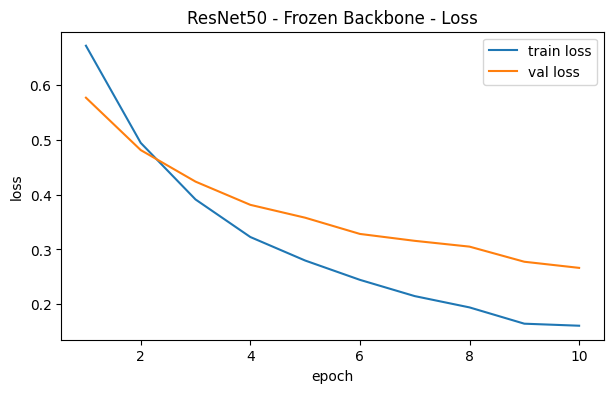

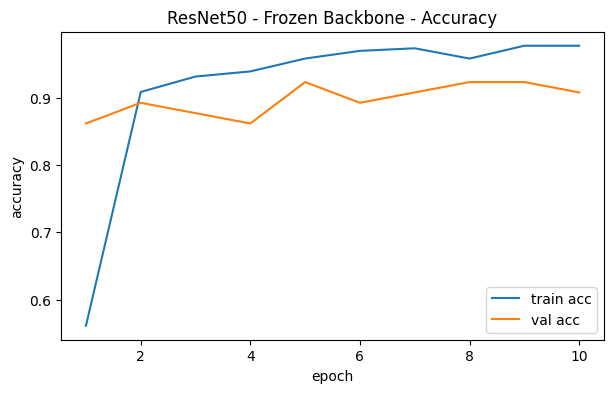

In [14]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,
    weight_decay=1e-4
)

history_freeze = fit(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=10
)

plot_history(history_freeze, "ResNet50 - Frozen Backbone")


In [18]:
print("Best val acc:", max(history_freeze["val_acc"]))


Best val acc: 0.9230769230769231


**What I expected:**  
Since the backbone is pretrained on ImageNet, I expected fast convergence and a decent validation accuracy even without fine-tuning.

**What I observed:**  
Training converged quickly and the validation accuracy reached ~0.92.  
The gap between train and validation curves stayed relatively small, which suggests good generalization and stable training.

**Conclusion:**  
Freezing the backbone already works very well on this dataset, but it may limit performance because the feature extractor cannot adapt to the specific domain.  
In the next experiment, I fine-tune the last ResNet block (layer4) to see if it improves validation accuracy.


## Step 7 - Experiment 2: Fine-Tuning the Last ResNet Block

After training only the classification head, I allow part of the pretrained network to adapt to the target dataset.
Specifically, I unfreeze layer4, the last convolutional block of ResNet50, while keeping the earlier layers frozen.

In [ ]:

# Unfreeze layer4
for param in model.layer4.parameters():
    param.requires_grad = True

# Verify trainable params
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"Trainable params after unfreeze: {trainable:,} / {total:,}")


Trainable params after unfreeze: 14,968,834 / 23,512,130


**Why fine-tune only layer4?**

- Early ResNet layers learn low-level features (edges, colors) that are generally useful across many tasks.
- The last block (layer4) captures higher-level, task-specific features.
- Fine-tuning only layer4 provides a balance between flexibility and overfitting, especially for a small dataset.

## Step 7 - Experiment 2: Fine-Tuning layer4 and the Classification Head

In this experiment, I fine-tune the last convolutional block of ResNet50 (layer4) together with the classification head.
To keep training stable, I use different learning rates:
- A smaller learning rate for the pretrained layer4
- A larger learning rate for the newly initialized classification head

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam([
    {"params": model.layer4.parameters(), "lr": 1e-4},
    {"params": model.fc.parameters(),"lr": 1e-3},
], weight_decay=1e-4)


Epoch 01/10 | train loss 0.1688 acc 0.958 | val loss 0.2055 acc 0.923
Epoch 02/10 | train loss 0.0396 acc 0.996 | val loss 0.2307 acc 0.892
Epoch 03/10 | train loss 0.0343 acc 0.992 | val loss 0.1977 acc 0.923
Epoch 04/10 | train loss 0.0141 acc 1.000 | val loss 0.2066 acc 0.938
Epoch 05/10 | train loss 0.0053 acc 1.000 | val loss 0.2226 acc 0.938
Epoch 06/10 | train loss 0.0039 acc 1.000 | val loss 0.2284 acc 0.938
Epoch 07/10 | train loss 0.0020 acc 1.000 | val loss 0.2318 acc 0.938
Epoch 08/10 | train loss 0.0102 acc 0.996 | val loss 0.2311 acc 0.938
Epoch 09/10 | train loss 0.0013 acc 1.000 | val loss 0.2204 acc 0.954
Epoch 10/10 | train loss 0.0035 acc 1.000 | val loss 0.2217 acc 0.969


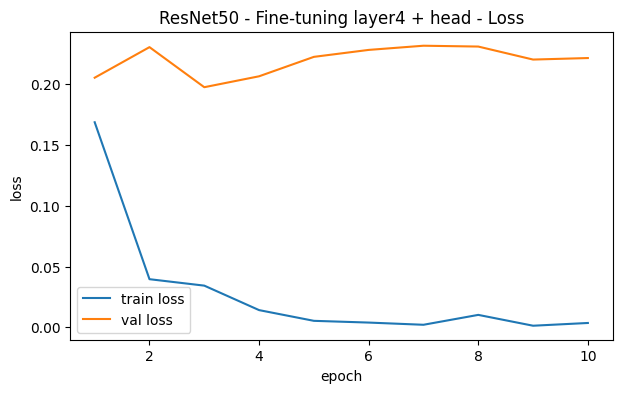

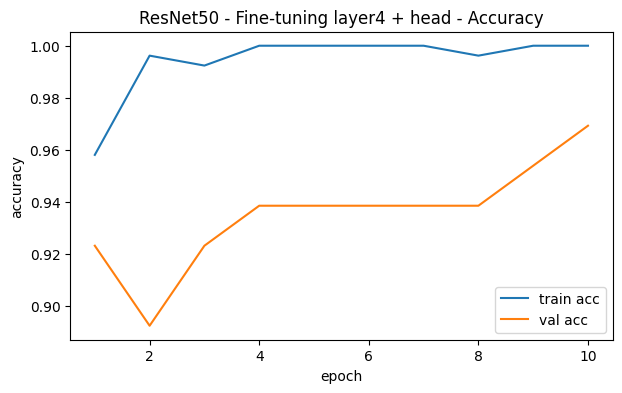

In [ ]:
history_finetune = fit(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=10
)

plot_history(history_finetune, "ResNet50 - Fine-tuning layer4 + head")


**Observations:**

- Training accuracy quickly reached 100%, which is expected given the small dataset and increased model flexibility.
- Validation accuracy improved compared to the frozen-backbone setup, reaching up to ~0.97.
- Training remained stable despite fine-tuning, thanks to the lower learning rate applied to the pretrained layers.

**Comparison with Experiment 1:**

Fine-tuning layer4 led to better validation performance than training only the classification head, indicating that adapting high-level features to the target dataset is beneficial.
